In [58]:
import json

with open("../data/raw/data.json", "r") as f:
    data = json.load(f)

type(data)

data.keys()

dict_keys(['metadata', 'timeseries'])

In [59]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
import pandas as pd

# open imported tmep min data from date to a year past
records = data["timeseries"]
df = pd.DataFrame(records)
df.head()

,PRCP,SNWD,TMAX,SNOW,TMIN
1968-06-01,0.00,0.0,70.0,0.0,51.0
1968-06-02,0.00,0.0,76.0,0.0,57.0
1968-06-03,0.00,0.0,74.0,0.0,55.0
1968-06-04,0.02,0.0,78.0,0.0,54.0
1968-06-05,0.00,0.0,76.0,0.0,54.0


In [61]:
df.index = pd.to_datetime(df.index)
df.index.name = "date"
df = df.sort_index()

df.info()
df.describe()

<class 'pandas.DataFrame'>
DatetimeIndex: 21063 entries, 1968-06-01 to 2026-01-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    21057 non-null  float64
 1   SNWD    20974 non-null  float64
 2   TMAX    21044 non-null  float64
 3   SNOW    20991 non-null  float64
 4   TMIN    20990 non-null  float64
dtypes: float64(5)
memory usage: 987.3 KB


,PRCP,SNWD,TMAX,SNOW,TMIN
count,21057.000000,20974.000000,21044.000000,20991.000000,20990.000000
mean,0.135345,0.338324,63.446731,0.074637,43.394712
std,0.371700,1.567704,18.683399,0.640831,16.968509
min,0.000000,0.000000,0.000000,0.000000,-13.000000
25%,0.000000,0.000000,48.000000,0.000000,30.000000
50%,0.000000,0.000000,65.000000,0.000000,43.000000
75%,0.060000,0.000000,80.000000,0.000000,58.000000
max,7.960000,25.000000,105.000000,19.800000,80.000000


In [62]:
# create the lag windows
df["TMIN_next"] = df["TMIN"].shift(-1)
df["TMIN_lag1"] = df["TMIN"].shift(1)
df["TMIN_lag7"] = df["TMIN"].shift(7)
df["TMAX_lag1"] = df["TMAX"].shift(1)

# drops missing rows
df = df.dropna()

In [63]:
df[[
    "TMIN",
    "TMIN_lag1",
    "TMIN_lag7",
    "TMAX_lag1",
    "TMIN_next"
]].head()

,TMIN,TMIN_lag1,TMIN_lag7,TMAX_lag1,TMIN_next
date,,,,,
1968-06-08,66.0,66.0,51.0,91.0,63.0
1968-06-09,63.0,66.0,57.0,92.0,67.0
1968-06-10,67.0,63.0,55.0,80.0,55.0
1968-06-11,55.0,67.0,54.0,88.0,55.0
1968-06-12,55.0,55.0,54.0,67.0,64.0


In [64]:
# naive predictor
df["pred_baseline"] = df["TMIN_lag1"]

# time-aware train/test split
train = df.loc[:'2015']
test = df.loc['2016':]

In [35]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(
    test["TMIN_next"],
    test["pred_baseline"]
)

print("Baseline MAE:", mae)

Baseline MAE: 7.0575402236160345


Baseline MAE 7.057 means our naive guess is around ~7*F off.
Add NOAA Edison TMIN data and initial exploration notebook.

IMPORTANT: Split the training and testing data into 80/20 split for this time series.

In [82]:
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

features = [
    "TMIN_lag1",
    "TMIN_lag7",
    "TMAX_lag1"
]

# placing features as the input
X_train = train[features]
y_train = train["TMIN_next"]

X_test = test[features]
y_test = test["TMIN_next"]

In [83]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)

# modeling weights
model.fit(X_train, y_train)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [85]:
pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, pred)

print("Ridge MAE: ", mae)

Ridge MAE:  6.338170545015577


In [88]:
df["TMIN_roll7"] = df["TMIN"].shift(1).rolling(7).mean()
df["TMIN_roll14"] = df["TMIN"].shift(1).rolling(14).mean()
df["TMIN_roll7_std"] = df["TMIN"].shift(1).rolling(7).std()

In [89]:
df = df.dropna()

In [90]:
features = [
    "TMIN_lag1",
    "TMIN_lag7",
    "TMAX_lag1",
    "TMIN_roll7",
    "TMIN_roll14"
]

In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

We need to scale the features because Ridge penalizes large coefficients. Some features may be on different scales leading to unfair regression and Alpha losing meaning.

In [92]:

from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)

In [93]:
import pandas as pd

""" 
Error:
    X_train_scaled = scaler.fit_transform(X_train)
        Converted DataFrame to NumPy array.
Fix:
    Pulling names from X_train for pd.DF() lib 
"""

feature_names = X_train.columns
coefficients = model.coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values(
    by="coefficient", 
    key=abs, 
    ascending=False
)

print(coef_df)

     feature  coefficient
0  TMIN_lag1     7.148128
2  TMAX_lag1     4.348248
1  TMIN_lag7     4.330154


In [ ]:
from sklearn.metrics import mean_absolute_error

# after scalar transform
print("Baseline MAE:", mean_absolute_error(y_test, test["pred_baseline"]))
print("Ridge MAE:", mean_absolute_error(y_test, pred))

Baseline MAE: 7.140087251575376
Ridge MAE: 6.552371689074692


In [95]:
import numpy as np

# place the features on a cyclic scale of day of year
# lets model learn season trends
# smooth periodic effects wihout sharp jumps at boundaries
df["day_of_year"] = df.index.dayofyear
df["sin_doy"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_doy"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

In [96]:
features = [
    "TMIN_lag1",
    "TMIN_lag7",
    "TMAX_lag1",
    "TMIN_roll7",
    "TMIN_roll14",
    "sin_doy",
    "cos_doy"
]

In [119]:
# Redo the cycle
# normalize the scale of features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# reapply ridge regression to min_cap/max_cap // normalize weights
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)
mean_absolute_error(y_test, pred)

print("Baseline MAE:", mean_absolute_error(y_test, test["pred_baseline"]))
print("Ridge MAE:", mean_absolute_error(y_test, pred))


Baseline MAE: 7.140087251575376
Ridge MAE: 6.338186299851732


In [30]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 14.2 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 13.3 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 12.8 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------- ----------------------- 2.9/7.0 MB 14.3 MB/s eta 0:00:01
   ---------------------------------- ----- 6.0/7.0 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 13.3 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ----- ----------------


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: title={'center': 'Residuals Over Time'}, xlabel='date'>

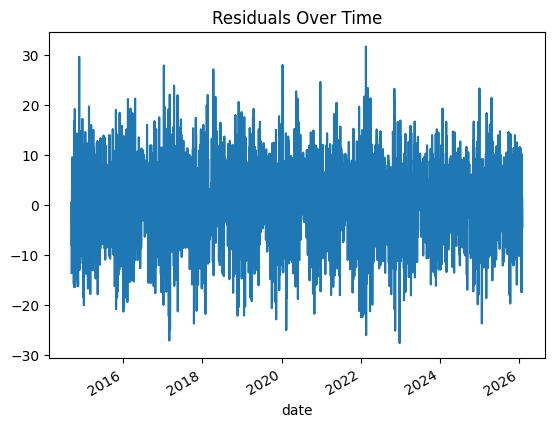

In [98]:
residuals = y_test - pred
residuals.plot(title="Residuals Over Time")

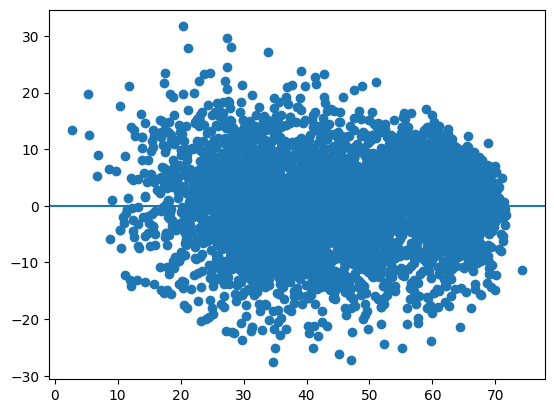

In [99]:
import matplotlib.pyplot as plt

plt.scatter(pred, residuals)
plt.axhline(0)

Residual diagnostics show no remaining linear structure, unducatung that theTide regression has captured most of the predictable signal in daily minimum temperature, and remaining error is dominated by stochastic weather varaibility.

In [100]:
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"

Since the linear regression model is already reaching it's predictive limit with the natural volitility of weather, we can see if adjusting it to find the MAE of the seasons can help.

In [101]:
season = y_test.index.month.map(get_season)

In [102]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

season_mae = {}

for s in ["winter", "spring", "summer", "fall"]:
    mask = season == s
    season_mae[s] = mean_absolute_error(
        y_test[mask],
        pred[mask]
    )

season_mae

{'winter': 7.191774330404198,
 'spring': 6.242336144058569,
 'summer': 5.239884590156876,
 'fall': 6.625695630025939}

In [103]:
season_mae_df = pd.DataFrame.from_dict(
    season_mae,
    orient="index",
    columns=["MAE"]
).sort_values("MAE")

season_mae_df

,MAE
summer,5.239885
spring,6.242336
fall,6.625696
winter,7.191774


In [105]:
baseline_pred = test["pred_baseline"]

season_mae_compare = {}

for s in ["winter", "spring", "summer", "fall"]:
    mask = season == s
    season_mae_compare[s] = {
        "baseline": mean_absolute_error(y_test[mask], baseline_pred[mask]),
        "ridge": mean_absolute_error(y_test[mask], pred[mask])
    }

pd.DataFrame(season_mae_compare)

,winter,spring,summer,fall
baseline,8.206897,7.137587,5.600000,7.546555
ridge,7.191774,6.242336,5.239885,6.625696


Next is error analysis:
    actual - prediction
    *** check if cluster by season or extreme temps

    lag feature upgrade
    add lag-2, lag-7
    rolling mean(3-7 days)

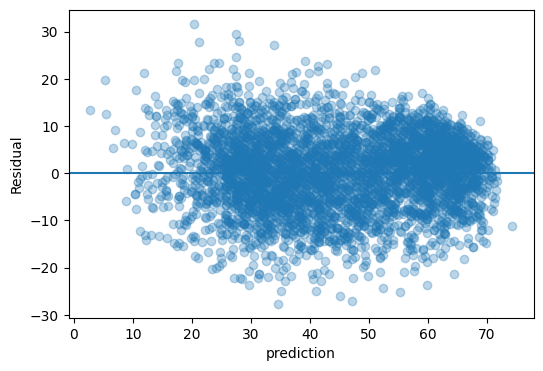

In [107]:
# Checking residuals (actual - prediction)

residuals = y_test - pred

plt.figure(figsize=(6,4))
plt.scatter(pred, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("prediction")
plt.ylabel("Residual")
plt.show()

In [114]:
bins = pd.qcut(y_test, q=5)

""" TEST CASE PRINTS: TRUE
print(type(pred))
print(y_test.index.equals(pred.index))
"""
pred = pd.Series(pred, index=y_test.index)
mae_by_bin = y_test.groupby(bins).apply(
    lambda x: mean_absolute_error(x, pred.loc[x.index])
    )

mae_by_bin

TMIN_next
(-2.001, 29.0]    7.504221
(29.0, 39.0]      5.985782
(39.0, 50.0]      6.654150
(50.0, 62.0]      5.602480
(62.0, 80.0]      5.907767
Name: TMIN_next, dtype: float64

In [123]:
pd.Series(
    model.coef_,
    index=X_train.columns
).sort_values()

TMIN_lag7    4.330154
TMAX_lag1    4.348248
TMIN_lag1    7.148128
dtype: float64

Coefficients are stable. No hidden dominant features. Errors are mostly in extremes. Seaonal MAE improvement has plateaued.

Linear ceiling has been hit. Apply a Regression Tree.

In [134]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print(pred_rf)

[61.06802641 51.97972401 50.96380848 ... 15.79481624 19.4072841
 16.23644497]


In [136]:
# check if RandomForest actually helped
rf_err = abs(y_test - pred_rf)
base_err = abs(y_test - X_test["TMIN_lag1"])

print((rf_err < base_err).mean())

0.5717401841977703


In [139]:
rf_mae = mean_absolute_error(y_test, pred_rf)
print("Random Forrest MAE:", rf_mae)

baseline_mae = mean_absolute_error(y_test, X_test["TMIN_lag1"])
print("Baseline MAE:", baseline_mae)


print("Ridge MAE:", mean_absolute_error(y_test, pred))

Random Forrest MAE: 6.402041633540414
Baseline MAE: 7.140087251575376
Ridge MAE: 6.338186299851732


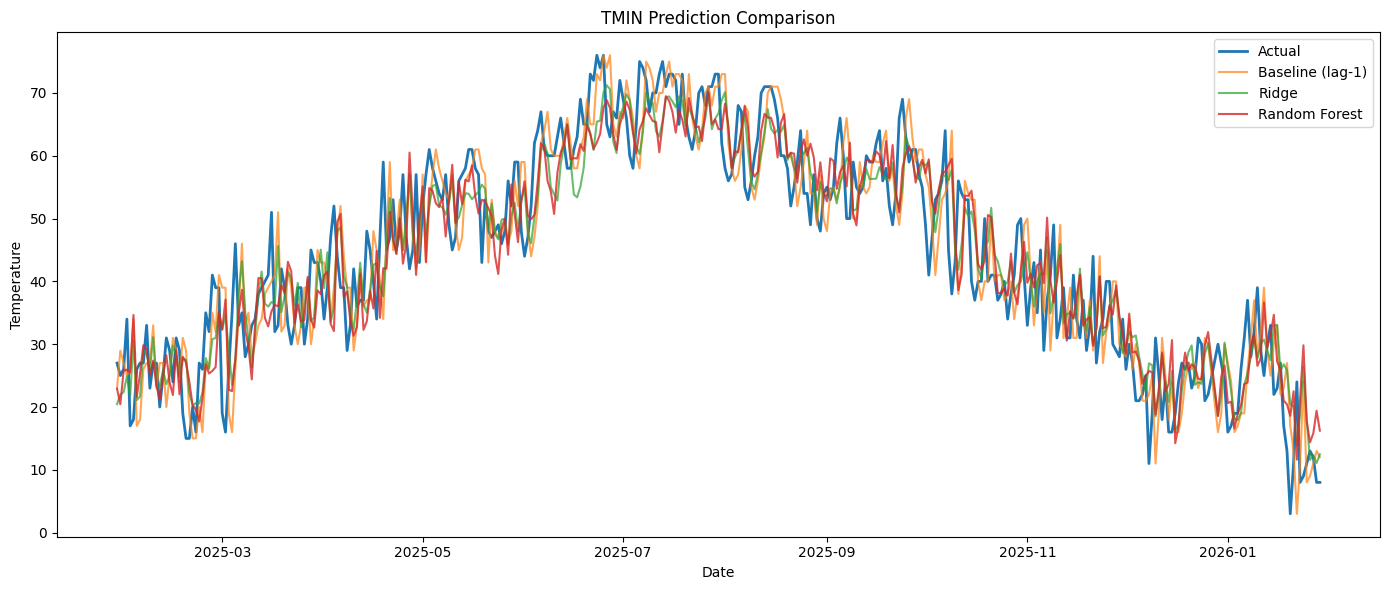

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.clf()

# just last year
plot_slice = slice(-365, None)

plt.plot(y_test.index[plot_slice], y_test.values[plot_slice], label="Actual", linewidth=2)
plt.plot(y_test.index[plot_slice], baseline_pred[plot_slice], label="Baseline (lag-1)", alpha=0.7)
plt.plot(y_test.index[plot_slice], pred[plot_slice], label="Ridge", alpha=0.7)
plt.plot(y_test.index[plot_slice], pred_rf[plot_slice], label="Random Forest", alpha=0.8)

plt.title("TMIN Prediction Comparison")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.tight_layout()
plt.show()


Analysis:
    Baseline
        - Closely follows
        - Misses sharp drops and rebounds
        - Always reacts late as a lag-1
    Ridge regression
        - Smoother than baseline
        - Handles seasonal structure well
        - Slightly underestimates extremes
    Random Forest
        - Tracks sharp changes better
        - Slightly less smooth
        